In [1]:
'''
This is a simple project that use logistic regression to find lead_score of customsers

Notes: 
- The debt-to-income (DTI) ratio measures the amount of 
income a person or organization generates in order to service a debt.

- A DTI of 43% is typically the highest ratio a borrower can have and 
still get qualified for a mortgage, but lenders generally seek ratios of no more than 36%.1

- A low DTI ratio indicates sufficient income relative to debt servicing, and it makes 
a borrower more attractive.

'''


import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import tqdm
import math
import os
import xgboost
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier



%matplotlib inline
# print(os.getcwd())
# os.listdir()

In [3]:
%cd "C:\Users\fenix\Downloads\Past\DSHomework-LeadScoring"


C:\Users\fenix\Downloads\Past\DSHomework-LeadScoring


In [4]:
df_raw = pd.read_csv('lead_scoring_homework.csv')
df_raw.shape

(125322, 14)

In [5]:
df_raw.head()

,lead_id,funded,created_datetime,assignment_datetime,loan_to_income,co_app_income,job_status,fico_score,loan_amount,loan_use,ndi_ratio,lead_source,open_accounts,clicked_offer
0,7599355,0,2021-09-11 17:42:44+00:00,2021-09-11 17:48:47+00:00,24.621212,0.0,Part-Time,668,32500,Debt Consolidation,0.232132,0,8,0
1,7600116,0,2021-09-11 21:57:35+00:00,2021-09-12 07:59:24+00:00,20.000000,0.0,Not Employed,792,40000,Other,0.146557,0,6,0
2,7599525,0,2021-09-11 18:29:20+00:00,2021-09-12 07:32:12+00:00,27.272727,0.0,Full-Time,755,30000,Home Improvement,0.510868,0,5,0
3,7599699,0,2021-09-11 19:24:46+00:00,2021-09-12 08:44:09+00:00,34.965035,0.0,Full-Time,677,20000,Debt Consolidation,0.457189,0,7,0
4,7599570,0,2021-09-11 18:40:24+00:00,2021-09-12 15:42:48+00:00,18.666667,0.0,Self-Employed,691,14000,Other,0.470130,0,3,0


### Feature Engineering

In [6]:

# get the age of the lead, defiend by assginment_time - created_time
# idea is to break the lead_age into 5 buckets, very_short, short, medium, long, very long
# they will be marked as 1,2,3,4,5

df_raw['created_datetime'] = pd.to_datetime(df_raw['created_datetime'] )
df_raw['assignment_datetime'] = pd.to_datetime(df_raw['assignment_datetime'] )
df_raw['lead_age'] = df_raw['assignment_datetime'] - df_raw['created_datetime']
df_raw['lead_age_seconds'] = df_raw['lead_age'].dt.total_seconds()


quantile_20 = df_raw['lead_age_seconds'].quantile(q=0.20)
quantile_40 = df_raw['lead_age_seconds'].quantile(q=0.40)
quantile_60 = df_raw['lead_age_seconds'].quantile(q=0.60)
quantile_80 = df_raw['lead_age_seconds'].quantile(q=0.80)

for i in range(df_raw.shape[0]):
    if df_raw.loc[i,'lead_age_seconds'] <= quantile_20 and df_raw.loc[i,'lead_age_seconds'] > 0:
        df_raw.loc[i,'lead_age_class'] = 1
    elif df_raw.loc[i,'lead_age_seconds'] > quantile_20 and df_raw.loc[i,'lead_age_seconds'] <= quantile_40:
        df_raw.loc[i,'lead_age_class'] = 2
    elif  df_raw.loc[i,'lead_age_seconds'] > quantile_40 and df_raw.loc[i,'lead_age_seconds'] <= quantile_60:
        df_raw.loc[i,'lead_age_class'] = 3
    elif  df_raw.loc[i,'lead_age_seconds'] > quantile_60 and df_raw.loc[i,'lead_age_seconds'] <= quantile_80:
        df_raw.loc[i,'lead_age_class'] = 4    
    else:
        df_raw.loc[i,'lead_age_class'] = 5

# df_raw
df_raw['lead_age_class'] = df_raw['lead_age_class'].astype(int)

In [9]:
# get the one hot coding for job_staus
# pd.get_dummies(df_raw['job_status'], prefix='job_status')

df_raw = pd.concat([df_raw, pd.get_dummies(df_raw['job_status'], prefix='job_status')],axis=1)
df_raw = pd.concat([df_raw, pd.get_dummies(df_raw['loan_use'], prefix='loan_use')],axis=1)

In [10]:
df_raw.to_csv('test.csv')

### Define the features and targets

In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125322 entries, 0 to 125321
Data columns (total 39 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   lead_id                           125322 non-null  int64              
 1   funded                            125322 non-null  int64              
 2   created_datetime                  125322 non-null  datetime64[ns, UTC]
 3   assignment_datetime               125322 non-null  datetime64[ns, UTC]
 4   loan_to_income                    125322 non-null  float64            
 5   co_app_income                     125322 non-null  float64            
 6   job_status                        125322 non-null  object             
 7   fico_score                        125322 non-null  int64              
 8   loan_amount                       125322 non-null  int64              
 9   loan_use                          125322 non-nul

In [13]:
df_raw.columns

Index(['lead_id', 'funded', 'created_datetime', 'assignment_datetime',
       'loan_to_income', 'co_app_income', 'job_status', 'fico_score',
       'loan_amount', 'loan_use', 'ndi_ratio', 'lead_source', 'open_accounts',
       'clicked_offer', 'lead_age', 'lead_age_seconds', 'lead_age_class',
       'job_status_Full-Time', 'job_status_Not Employed', 'job_status_Other',
       'job_status_Part-Time', 'job_status_Retired',
       'job_status_Self-Employed', 'loan_use_Auto Purchase',
       'loan_use_Business Expenses', 'loan_use_Credit Card Refinancing',
       'loan_use_Credit card refinancing', 'loan_use_Debt Consolidation',
       'loan_use_Debt consolidation', 'loan_use_Home Improvement',
       'loan_use_Home improvement', 'loan_use_Major Purchase',
       'loan_use_Medical Expenses', 'loan_use_Moving Expenses',
       'loan_use_Other', 'loan_use_Refi Cplus Loan', 'loan_use_Refi Fp Loan',
       'loan_use_Travel/Vacation', 'loan_use_Wedding'],
      dtype='object')

In [14]:
input_columns = [
    'funded',
    'loan_to_income',
    'co_app_income',
    'fico_score',
    'loan_amount',
    'ndi_ratio',
    'lead_source', # this one is a little bit probmatic, since it may be a categorical variable
    'open_accounts',
    'clicked_offer',
    'lead_age_seconds',
    'lead_age_class', # Below are all one-hot coding features from the job_status and loan_use
    'job_status_Full-Time', 'job_status_Not Employed', 'job_status_Other',
    'job_status_Part-Time', 'job_status_Retired',
    'job_status_Self-Employed', 'loan_use_Auto Purchase',
    'loan_use_Business Expenses', 'loan_use_Credit Card Refinancing',
    'loan_use_Credit card refinancing', 'loan_use_Debt Consolidation',
    'loan_use_Debt consolidation', 'loan_use_Home Improvement',
    'loan_use_Home improvement', 'loan_use_Major Purchase',
    'loan_use_Medical Expenses', 'loan_use_Moving Expenses',
    'loan_use_Other', 'loan_use_Refi Cplus Loan', 'loan_use_Refi Fp Loan',
    'loan_use_Travel/Vacation', 'loan_use_Wedding'
]


In [15]:
# define the input into the model based on selected features

df_input = df_raw[input_columns]
df_input.to_csv('test.csv')

In [16]:
feature_columns = [
    'loan_to_income',
    'co_app_income',
    'fico_score',
    'loan_amount',
    'ndi_ratio',
    'lead_source', # this one is a little bit probmatic, since it may be a categorical variable
    'open_accounts',
    'clicked_offer',
    'lead_age_seconds',
    'lead_age_class', # Below are all one-hot coding features from the job_status and loan_use
    'job_status_Full-Time', 'job_status_Not Employed', 'job_status_Other',
    'job_status_Part-Time', 'job_status_Retired',
    'job_status_Self-Employed', 'loan_use_Auto Purchase',
    'loan_use_Business Expenses', 'loan_use_Credit Card Refinancing',
    'loan_use_Credit card refinancing', 'loan_use_Debt Consolidation',
    'loan_use_Debt consolidation', 'loan_use_Home Improvement',
    'loan_use_Home improvement', 'loan_use_Major Purchase',
    'loan_use_Medical Expenses', 'loan_use_Moving Expenses',
    'loan_use_Other', 'loan_use_Refi Cplus Loan', 'loan_use_Refi Fp Loan',
    'loan_use_Travel/Vacation', 'loan_use_Wedding'
]

In [17]:

Y = df_input['funded'].to_numpy() 
Y



array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [18]:
X = df_input[feature_columns]
X

,loan_to_income,co_app_income,fico_score,loan_amount,ndi_ratio,lead_source,open_accounts,clicked_offer,lead_age_seconds,lead_age_class,...,loan_use_Home Improvement,loan_use_Home improvement,loan_use_Major Purchase,loan_use_Medical Expenses,loan_use_Moving Expenses,loan_use_Other,loan_use_Refi Cplus Loan,loan_use_Refi Fp Loan,loan_use_Travel/Vacation,loan_use_Wedding
0,24.621212,0.0,668,32500,0.232132,0,8,0,363.0,2,...,0,0,0,0,0,0,0,0,0,0
1,20.000000,0.0,792,40000,0.146557,0,6,0,36109.0,4,...,0,0,0,0,0,1,0,0,0,0
2,27.272727,0.0,755,30000,0.510868,0,5,0,46972.0,4,...,1,0,0,0,0,0,0,0,0,0
3,34.965035,0.0,677,20000,0.457189,0,7,0,47963.0,4,...,0,0,0,0,0,0,0,0,0,0
4,18.666667,0.0,691,14000,0.470130,0,3,0,75744.0,5,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125317,27.777778,72000.0,749,40000,0.518384,0,13,0,29612.0,4,...,0,0,0,0,0,0,0,0,0,0
125318,13.913043,0.0,622,16000,0.214386,11,9,0,79328.0,5,...,0,0,0,0,0,0,0,0,0,0
125319,21.686747,0.0,812,18000,0.304768,17,24,0,21.0,1,...,0,0,0,0,0,0,0,0,0,0
125320,14.285714,0.0,654,10000,0.417938,0,3,0,353128.0,5,...,0,0,0,0,0,1,0,0,0,0


In [19]:
# Standardize input data X
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X



array([[ 0.10960201, -0.02128867, -0.93863921, ..., -0.01852657,
        -0.03967903, -0.05161622],
       [-0.39005172, -0.02128867,  1.35305638, ..., -0.01852657,
        -0.03967903, -0.05161622],
       [ 0.39628857, -0.02128867,  0.66924399, ..., -0.01852657,
        -0.03967903, -0.05161622],
       ...,
       [-0.20767761, -0.02128867,  1.7226847 , ..., -0.01852657,
        -0.03967903, -0.05161622],
       [-1.00789052, -0.02128867, -1.19737904, ..., -0.01852657,
        -0.03967903, -0.05161622],
       [-0.55023215, -0.02128867,  1.24216788, ..., -0.01852657,
        -0.03967903, -0.05161622]])

### Study the correlation and coliniarity

<AxesSubplot:>

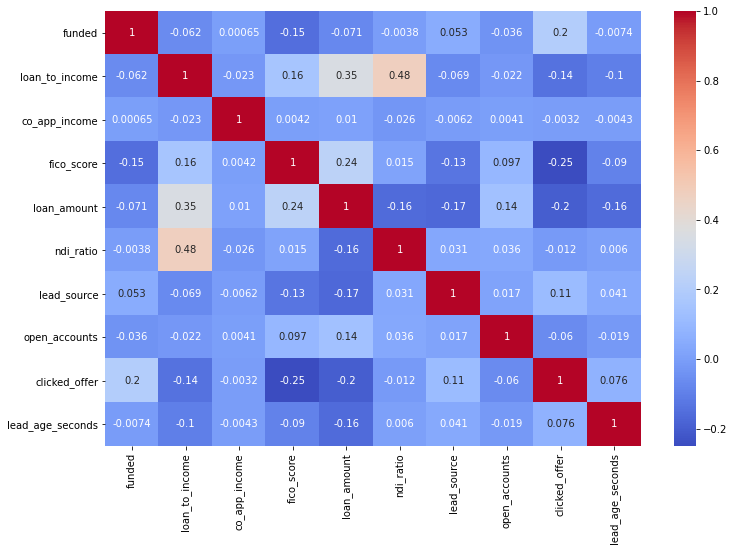

In [20]:
corr = df_input.iloc[:,0:10].corr()
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(corr, cmap="coolwarm", annot=True)

<AxesSubplot:>

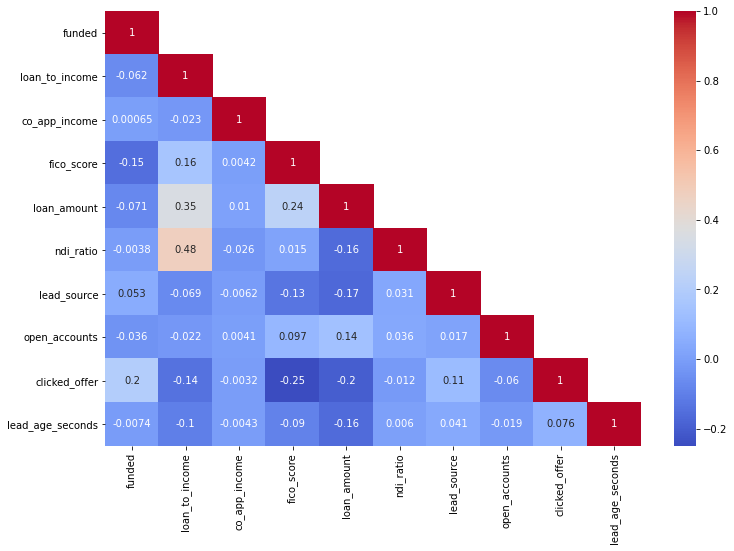

In [21]:
lower_triang_df = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(lower_triang_df, cmap="coolwarm", annot=True)



In [22]:
# the coliarity problem is minor

### Train-Validation-Test split

In [23]:
# split train and test dataset
### Since we are going to test several different model, we are going to split the data
### into 80% and 20% split



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print('*'*100)
print('make sure the data is nearly stratified, to avoid unbalanced train and test data')
print(sum(Y_train))
print(sum(Y_test))
print('here seems the train and test true labels are porportionally to its total size, good to go!')

(100257, 32)
(25065, 32)
(100257,)
(25065,)
****************************************************************************************************
make sure the data is nearly stratified, to avoid unbalanced train and test data
7202
1794
here seems the train and test true labels are porportionally to its total size, good to go!


### Dummy Classifier to test imbalnaced dataset

In [24]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,Y_train)
Y_pred = clf.predict(X_test)

#Distribution of y test
print('y actual : \n' +  str(pd.Series(Y_test).value_counts()))

#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(Y_pred).value_counts()))

y actual : 
0    23271
1     1794
dtype: int64
y predicted : 
0    25065
dtype: int64


In [25]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(Y_test,Y_pred)))
print('Precision Score : ' + str(precision_score(Y_test,Y_pred)))
print('Recall Score : ' + str(recall_score(Y_test,Y_pred)))
print('F1 Score : ' + str(f1_score(Y_test,Y_pred)))

#Dummy Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(Y_test,Y_pred)))

# this means that if we assume everything is 0, the accuracy is 92.8% not very helpful 

Accuracy Score : 0.928426092160383
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
Confusion Matrix : 
[[23271     0]
 [ 1794     0]]


### Train the logistic regression

In [50]:
parameters ={'C':[0.01,0.1,0.5,1,3,5,7,9],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [51]:
parameters ={"C":[0.01,0.1,1,10],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
gscv = GridSearchCV(lr, parameters, scoring='roc_auc', cv=5)
logreg_cv = gscv.fit(X_train,Y_train)

In [52]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7553560152641429


### Test the logistic regression

In [53]:

# confusion matrix to be used
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not Closed', 'Closed']); ax.yaxis.set_ticklabels(['Not Closed', 'Closed'])

In [54]:
print('Accuracy for LR on Test Data with best parameter=  ',logreg_cv.score(X_test,Y_test))

Accuracy for LR on Test Data with best parameter=   0.7549038911258729


Best Threshold=0.068440, G-Mean=0.691


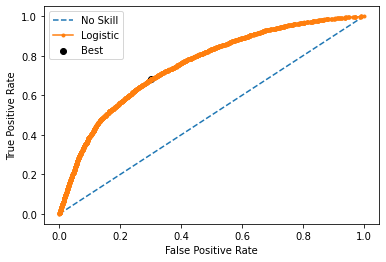

Best Threshold=0.068440, G-Mean=0.691


In [59]:
# lr_probs = pred_proba[:, 1]
# lr_probs
from sklearn.metrics import roc_curve
from matplotlib import pyplot

pred_proba = logreg_cv.predict_proba(X_test)

yhat = pred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

# locate the index of the largest g-mean
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Accuracy Score : 0.6981448234590066
Precision Score : 0.14881966415186176
Recall Score : 0.6817168338907469
F1 Score : 0.2443068318018378


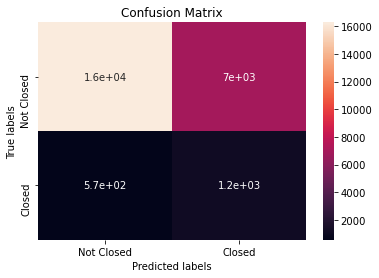

In [60]:

# cannot use yhat=logreg_cv.predict(X_test) because the 
# threshold 0.5 is too low

threshold = 0.068530

yhat = []

for pred in pred_proba:
    # print(pred[1])
    if pred[1] > threshold:
        yhat.append(1)
    else:
        yhat.append(0)
    

yhat = np.array(yhat)


plot_confusion_matrix(Y_test,yhat)

print('Accuracy Score : ' + str(accuracy_score(Y_test,yhat)))
print('Precision Score : ' + str(precision_score(Y_test,yhat)))
print('Recall Score : ' + str(recall_score(Y_test,yhat)))
print('F1 Score : ' + str(f1_score(Y_test,yhat)))

In [61]:
# with the threshold = 0.068530
# we find the best balanced results with good recall and f1-score 


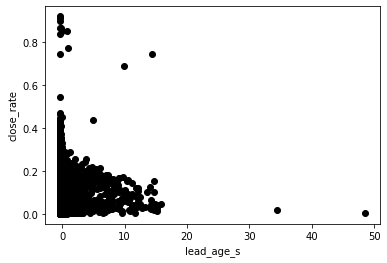

In [62]:
# this is the lead_age_second 

lead_age_second = X_test[:,8]

yhat = pred_proba[:, 1]


pyplot.scatter(lead_age_second, yhat, marker='o', color='black')
pyplot.xlabel('lead_age_s')
pyplot.ylabel('close_rate')

pyplot.show()